In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

<h3>data analysis<h3>

In [2]:
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'image_manipulation.ipynb',
 'image_rewrite.ipynb',
 'models',
 'models_e',
 'pictures',
 'rps_cnn.ipynb',
 'rps_cnn_edge_rec.ipynb',
 'rps_cnn_predictor.ipynb',
 'rps_cnn_predictor_edge_rec.ipynb',
 'test',
 'test_e',
 'train',
 'train_e']

In [3]:
os.listdir('test_e')

['paper', 'rock', 'scissors']

In [4]:
os.listdir('train_e')

['paper', 'rock', 'scissors']

In [5]:
rock_dir = 'train_e\\rock\\' + os.listdir('train_e\\rock')[0]

In [6]:
rock_img = imread(rock_dir)

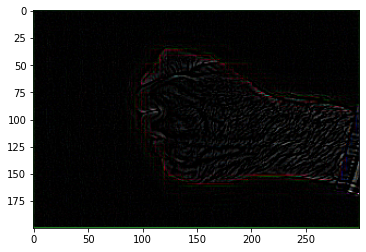

In [7]:
plt.imshow(rock_img)

In [8]:
# rock_img

In [9]:
rock_img.max()

1.0

In [10]:
rock_img.min()

0.0

In [11]:
rock_img.shape

(200, 300, 3)

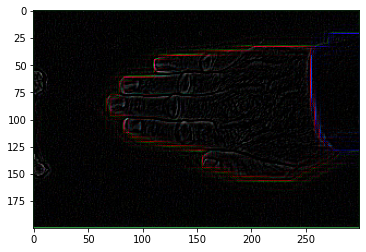

In [12]:
paper_dir = 'train_e\\paper\\' + os.listdir('train_e\\paper')[0]
paper_img = imread(paper_dir)
plt.imshow(paper_img)

In [13]:
paper_img.shape

(200, 300, 3)

In [14]:
len(os.listdir('train_e\\rock'))

626

In [15]:
len(os.listdir('train_e\\paper'))

612

In [16]:
len(os.listdir('train_e\\scissors'))

650

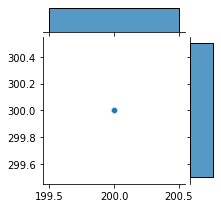

In [17]:
dim1 = []
dim2 = []
for dir1 in ['train_e\\','test_e\\']:
    for dir2 in os.listdir(dir1):
        for img_name in os.listdir(dir1 + dir2): 
            img = imread(dir1 + dir2 + '\\' + img_name)
            d1,d2,colors = img.shape
            dim1.append(d1)
            dim2.append(d2)
sns.jointplot(x=dim1,y=dim2,height=3)

<h3>preparing image generator<h3>

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
# help(ImageDataGenerator)

In [20]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               rescale=1/255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='constant',
                               cval=.0
                              )

In [21]:
rock_img[0][0][0]

0.0627451

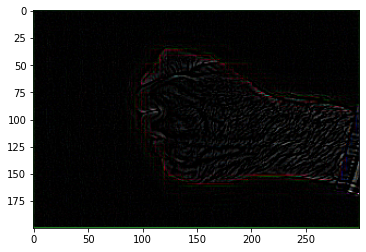

In [22]:
plt.imshow(rock_img)

In [23]:
image_gen.random_transform(rock_img)[0][0][0]

0.0

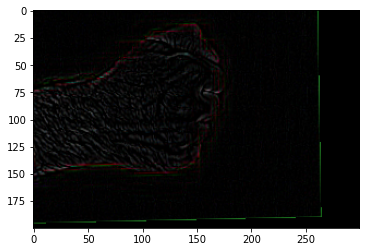

In [24]:
plt.imshow(image_gen.random_transform(rock_img))

In [25]:
image_gen.flow_from_directory('train_e')

Found 1888 images belonging to 3 classes.


In [26]:
image_gen.flow_from_directory('test_e')

Found 300 images belonging to 3 classes.


<h3>creating model<h3>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [28]:
image_shape = (60, 90, 1)

In [29]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 88, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 44, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 42, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 21, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8736)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1118336   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

<h3>training the model<3>

In [33]:
# help(image_gen.flow_from_directory)

In [34]:
batch_size = 16

In [35]:
train_image_gen = image_gen.flow_from_directory('train',
                                                target_size=image_shape[:2],
                                                color_mode='grayscale',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 1888 images belonging to 3 classes.


In [36]:
test_image_gen = image_gen.flow_from_directory('test',
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 300 images belonging to 3 classes.


In [37]:
train_image_gen.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [38]:
results = model.fit(train_image_gen,
                    epochs=20,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

Epoch 1/20
118/118 [==============================] - 11s 91ms/step - loss: 1.0112 - accuracy: 0.4608 - val_loss: 0.8396 - val_accuracy: 0.5500
Epoch 2/20
118/118 [==============================] - 13s 106ms/step - loss: 0.7530 - accuracy: 0.6367 - val_loss: 0.6921 - val_accuracy: 0.6867
Epoch 3/20
118/118 [==============================] - 13s 113ms/step - loss: 0.6383 - accuracy: 0.7119 - val_loss: 0.6605 - val_accuracy: 0.7633
Epoch 4/20
118/118 [==============================] - 13s 107ms/step - loss: 0.5862 - accuracy: 0.7505 - val_loss: 0.5961 - val_accuracy: 0.7400
Epoch 5/20
118/118 [==============================] - 12s 106ms/step - loss: 0.4950 - accuracy: 0.7945 - val_loss: 0.5090 - val_accuracy: 0.7867
Epoch 6/20
118/118 [==============================] - 14s 117ms/step - loss: 0.4195 - accuracy: 0.8337 - val_loss: 0.5081 - val_accuracy: 0.8000
Epoch 7/20
118/118 [==============================] - 13s 113ms/step - loss: 0.3795 - accuracy: 0.8543 - val_loss: 0.3207 - val_acc

In [39]:
from datetime import datetime

In [40]:
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M")

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save('models_e\\' + timestamp)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models_e\2020-11-04--19-15\assets


<h3>model evaluation<h3>

In [43]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

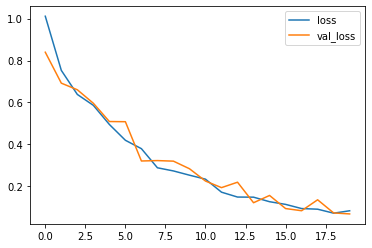

In [44]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

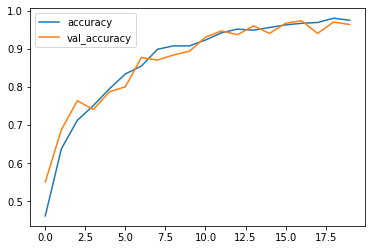

In [45]:
losses[['accuracy','val_accuracy']].plot()

In [46]:
model.metrics_names

['loss', 'accuracy']

In [47]:
model.evaluate(test_image_gen)

19/19 [==============================] - 1s 67ms/step - loss: 0.1063 - accuracy: 0.9533


[0.10627388209104538, 0.95333331823349]

In [48]:
pred_probabilities = model.predict(test_image_gen)

In [49]:
pred_probabilities

array([[9.99910474e-01, 5.25005134e-07, 8.90044612e-05],
       [9.99979377e-01, 5.86931970e-09, 2.06165787e-05],
       [8.56102467e-01, 1.42867729e-01, 1.02986943e-03],
       [9.99996305e-01, 2.72378043e-06, 9.88527745e-07],
       [9.99999642e-01, 9.42426155e-08, 1.86783950e-07],
       [9.02929902e-01, 4.69367777e-04, 9.66006741e-02],
       [2.39088267e-01, 9.79038959e-05, 7.60813773e-01],
       [5.10461569e-01, 4.48581785e-01, 4.09566984e-02],
       [9.91816700e-01, 8.12138990e-03, 6.19499187e-05],
       [9.99569118e-01, 4.24491009e-04, 6.47683282e-06],
       [9.97476995e-01, 7.38976667e-08, 2.52291886e-03],
       [9.99745667e-01, 2.52667407e-04, 1.64295170e-06],
       [9.98605669e-01, 1.18399342e-07, 1.39422494e-03],
       [9.99997497e-01, 1.68397082e-06, 7.84452595e-07],
       [9.39320803e-01, 5.27316481e-02, 7.94755574e-03],
       [9.99987125e-01, 8.61735680e-06, 4.27080158e-06],
       [9.99998331e-01, 1.08601000e-07, 1.58601506e-06],
       [9.46849585e-01, 2.21185

In [50]:
pred_probabilities.shape

(300, 3)

In [51]:
test_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [52]:
from sklearn.metrics import classification_report,confusion_matrix

In [53]:
predictions = np.argmax(model.predict(test_image_gen), axis=-1)

In [54]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       100
           1       0.99      0.96      0.97       100
           2       0.95      0.97      0.96       100

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [55]:
confusion_matrix(test_image_gen.classes,predictions)

array([[95,  1,  4],
       [ 3, 96,  1],
       [ 3,  0, 97]], dtype=int64)